# Adatelemzés a gyakorlatban Python Pandas és Scikit-learn alapokon

Laczkó Anna - GQXHDA

---



# LLM

A feladat megoldása során segítségül vettem a ChatGPT-t. A felhasználás egyrészt a gyorsabb kódolás érdekében kódgenerálás volt megadott promptok alapján, illetve debugolás, amikor elakadtam egy hibánál.

# Könyvtárak és adathalmaz

In [3]:
#szükséges könyvtárak telepítése
!pip install matplotlib
!pip install langdetect
!pip install iso-639
!pip install plotly


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/15.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/15.6 MB ? eta -:--:--
   ---------------------------------------- 0.1/15.6 MB 991.0 kB/s eta 0:00:16
   - -------------------------------------- 0.5/15.6 MB 4.7 MB/s eta 0:00:04
   --- ------------------------------------ 1.2/15.6 MB 7.8 MB/s eta 0:00:02
   ----- ---------------------------------- 2.3/15.6 MB 11.1 MB/s eta 0:00:02
   --------- ------------------------------ 3.7/15.6 MB 14.9 MB/s eta 0:00:01
   --------------- ------------------------ 6.0/15.6 MB 20.1 MB/s eta 0:00:01
   ------------------------ --------------- 9.4/15.6 MB 27.4 MB/s eta 0:00:01
   ------------------------------------- -- 14.6/15.6 MB 73.1 MB/s eta 0:00:01
   ---------------------------------------  15.6/15.6 MB 93.9 MB/s eta 0:00:01
   ---------------------------------------- 15.6/15.6 MB 59.5 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
#szükséges könyvtárak importálása
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
from iso639 import languages
from langdetect import detect
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import re
import gc
import copy
import csv
import operator
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from itertools import islice
from sklearn.model_selection import RandomizedSearchCV

In [6]:
#adathalmaz beolvasása
og_df = pd.read_csv('data/TMDB_tv_dataset_v3.csv')

In [ ]:
# # Colabban futtatás esetén a drive-om gyökérmappájában helyeztem el az adathalmazt. Annak betöltéséhez ez kell

# from google.colab import drive
# drive.mount('/content/drive')
# og_df = pd.read_csv('drive/MyDrive/TMDB_tv_dataset_v3.csv')

Mounted at /content/drive


# Feladatok
A feladataimat a specifikációmhoz képest újrarendeztem úgy, ahogy úgy gondolom, hogy logikus lenne nekem végighaladni


1. Azonosítsa a legtermékenyebb tévéműsor-alkotókat vagy produkciós cégeket az általuk készített műsorok száma alapján.
2. Fedezze fel a tévéműsorok népszerűségének trendjeit és fő tényezőit
    1. Jósolja meg egy tévéműsor sikerét olyan jellemzők alapján, mint a szavazatszám, az átlag és a népszerűség.
    2. Elemezze a tévéműsorok nyelve és népszerűsége közötti kapcsolatot, és vizsgálja meg a nem angol nyelvű műsorok népszerűségét.
        1. Ennél célom, hogy az adatokat tudjam valahogy a nyelvek szerint normalizálni, hogy így mérhető legyen egy angol nyelvű, illetve egy idegen nyelvű sorozat sikeressége egymáshoz.
    
5. Ezek mellett szeretném az adathalmazt alaposabban átvizsgálni és további összefüggéseket keresni.

# Elemzés

In [ ]:
og_df.isna().sum()

id                           0
name                         5
number_of_seasons            0
number_of_episodes           0
original_language            0
vote_count                   0
vote_average                 0
overview                 73323
adult                        0
backdrop_path            88798
first_air_date           31347
last_air_date            29498
homepage                115110
in_production                0
original_name                5
popularity                   0
poster_path              58786
type                         0
status                       0
tagline                 160262
genres                   67208
created_by              129558
languages                57051
networks                 69048
origin_country           31023
spoken_languages         57798
production_companies    107039
production_countries     89170
episode_run_time             0
dtype: int64

## Függvények
A feladat megkönnyítése érdekében létrehoztam néhány függvényt a többször használt kódokhoz

In [ ]:
dummy_columns=[]

In [ ]:
# visszaadja a nyelv nevét a nyelv kódneve alapján (en -> English)

def get_language_name(language_code):
    try:
        return languages.get(part1=language_code).name
    except (KeyError, AttributeError):
        return "Unknown"  # Vagy tetszőleges érték, amit szeretnél az ismeretlen nyelv esetén

In [ ]:
#dummy oszlopokat csinál a megadott oszlopból. Az eredeti oszlopot eldobja

def dummy_creator(df, col):
    ps_dummies = pd.get_dummies(df[col], prefix = col, drop_first = False)
    df = df.merge(ps_dummies, left_index = True, right_index = True, how = 'left')
    df=df.drop(col, axis=1)

    return df

In [ ]:
#dummy oszlopokat csinál olyan oszlopokból, ahol az oszlop több értéket is felvehet egyszerre. Az eredeti oszlopot eldobja.

def dummy_creator_for_list_values(df, col, language):

    #értékek listává alakítása
    df['col_split'] = df[col].apply(lambda x: [s.strip() for s in re.split(', | & ', x)] if isinstance(x, str) else None)

    cols=['id', 'col_split']

    df2=df[cols].copy()

    dummy_cols=set()

    #oszlopok létrehozása
    for index, row in df2.iterrows():
        if row['col_split'] is not None:
            for item in row['col_split']:
                if language:
                    item=get_language_name(item)
                dummy_col = col + '_' + item
                dummy_cols.add(dummy_col)

    dummy_cols=list(set(dummy_cols))

    empty_df=pd.DataFrame(columns=dummy_cols)

    new_df=pd.concat([df, empty_df], axis=1)

    new_df[dummy_cols]=new_df[dummy_cols].fillna(0)

    #új oszlopokban a flagek beállítása
    for index, row in new_df.iterrows():
        if row['col_split'] is not None:
            for item in row['col_split']:
                if language:
                    item=get_language_name(item)
                dummy_col = col + '_' + item
                new_df.at[index, dummy_col] = 1

    del new_df['col_split']

    return new_df


In [ ]:
#adatelemzéshez a dataframe átalakítása. A dummycreator-oknál printel, hogy lehessen követni a haladást. Lassú, de igyekeztem optimalizálni

def dataprep(df):

    df=df.dropna(subset='name')

    df['original_language'].value_counts()
    df['OG_language'] = df['original_language'].apply(lambda x: get_language_name(x))

    df= dummy_creator(df, 'OG_language')
    del df['overview']

    df['adult'] = df['adult'].astype(np.int8)

    del df['backdrop_path']

    df['first_air_date']=pd.to_datetime(df['first_air_date'])
    mindate=df['first_air_date'].min()
    # maxdate=df['first_air_date'].max()

    df['startdate']=(df['first_air_date']-mindate).dt.days
    df['startdate']=df['startdate'].fillna(-1)
    del df['first_air_date']
    del df['last_air_date']
    df['has_homepage'] = df['homepage'].apply(lambda x: 0 if pd.isna(x) else 1)

    del df['homepage']
    del df['in_production']
    del df['original_name']
    del df['poster_path']
    print('dummy0')
    df=dummy_creator(df, 'type')
    print('dummy1')
    df=dummy_creator(df, 'status')
    # del df['status']
    del df['tagline']
    print('dummy2')
    df= dummy_creator_for_list_values(df, 'genres', False)

    del df['genres']


    del df['created_by']

    df ['languages']=df ['languages'].fillna(df['original_language'])

    del df['original_language']
    print('dummy3')
    df= dummy_creator_for_list_values(df, 'languages', True)

    del df['languages']

    print('dummy4')
    # df= dummy_creator_for_list_values(df, 'networks', False)
    del df['networks']
    del df['origin_country']
    del df['spoken_languages']
    del df['production_countries']
    del df['production_companies']

    copy=df.copy()

    return copy

In [ ]:
# Mean absolute percentage error kiszámolása

def calculate_mape(y_true, y_pred):
    mask = y_true != 0
    y_true_masked = y_true[mask]
    y_pred_masked = y_pred[mask]

    absolute_percentage_error = np.abs((y_true_masked - y_pred_masked) / y_true_masked)

    mape = np.mean(absolute_percentage_error) * 100

    return mape

In [ ]:
# továbbfejlesztett value_counts, az olyan oszlopok feldolgozására, ahol rekordokként több értéke is lehet egy oszlopnak. Visszaad egy rendezett dictionaryt róla

def dict_for_list_values(df, col):
    df= df[df[col].apply(lambda x: isinstance(x, str))].copy()

    df['col_split'] = df[col].apply(lambda x: [s.strip() for s in re.split(', | & ', x)])

    col_dict={}

    for index, row in df.iterrows():
        for item in row['col_split']:
            if item not in (col_dict):
                col_dict[item]=1
            else:
                col_dict[item]+=1

    ordered_col_dict = dict(sorted(col_dict.items(), key=lambda x: x[1], reverse=True))
    return ordered_col_dict

## 1. Feladat: Legtermékenyebb tévéműsor-alkotók és produkciós cégek
Ennél a feladatnál a legnagyobb problémát az jelentette, hogy az oszlopokat jól fel lehessen dolgozni. Erre létrehoztam a *dict_for_list_values* függvényt, ami egy továbbfejlesztett *value_counts*

### production_companies

In [ ]:
df_pc=og_df.copy()

In [ ]:
df_pc['production_companies'].value_counts()

TVB                                                                                       1356
BBC                                                                                        544
Estúdios Globo                                                                             531
NHK                                                                                        455
DR TV                                                                                      324
                                                                                          ... 
ABC News Studios, ABC News                                                                   1
Estúdios Globo, Glaz Entretenimento                                                          1
ZRF "Kamera"                                                                                 1
Lakeside Animation, Art Light, Look Mom! Productions, MetraFilms, Nukufilm, Riki Group       1
Feelgood Bangkok, h8 Studio                       

In [ ]:
df_pc['production_companies'].isna().sum()

107039

In [ ]:
df_pc=df_pc.dropna(subset='production_companies')

In [ ]:
dict_pc=dict_for_list_values(df_pc, 'production_companies') #fejlesztett value_counts

In [ ]:
for key, value in islice(dict_pc.items(), 20):
    print(f"{key}: {value}")

TVB: 1388
BBC: 867
Estúdios Globo: 631
NHK: 576
Česká televize: 395
Warner Bros. Television: 380
Televisa: 347
Universal Television: 346
DR TV: 343
TV 2: 333
ZDF: 319
ARTE: 316
Fuji Television Network: 299
GMA Entertainment Group: 292
TBS: 284
RAI: 278
TV Tokyo: 272
ATV Enterprises Limited: 271
SVT: 269
Amazon Studios: 267


Így láthatjuk, hogy mi a 20 legtermékenyebb production company. A top 5-ben van brit, honkongi, latin-amerikai, japán és cseh.
A legmeglepőbbnek azt tartom, hogy egy olyan kis ország csatornája is bejutott a listára, mint Csehország, illetve, hogy amerikai társaság nincs benne.

In [ ]:
del df_pc

### created_by

In [ ]:
df_cb=og_df.copy()

In [ ]:
df_cb['created_by'].value_counts()

Shotaro Ishinomori                                                   106
Adrián Suar                                                           64
John de Mol                                                           63
Simon Fuller                                                          48
Ekta Kapoor                                                           46
                                                                    ... 
Grits Carter, Antonia F. March, Jacqueline McKinley, Omar Shamout      1
Jo Sung-hee                                                            1
Jari Rantala                                                           1
Arif Khan                                                              1
Erik Range                                                             1
Name: created_by, Length: 25719, dtype: int64

In [ ]:
df_cb['created_by'].isna().sum()

129558

In [ ]:
df_cb=df_cb.dropna(subset='created_by')

In [ ]:
dict_cb=dict_for_list_values(df_cb, 'created_by') #fejlesztett calue_counts

In [ ]:
for key, value in islice(dict_cb.items(), 20):
    print(f"{key}: {value}")

Shotaro Ishinomori: 113
John de Mol: 88
Adrián Suar: 71
Simon Fuller: 64
Joseph Barbera: 52
William Hanna: 52
Ekta Kapoor: 51
Na Young-seok: 49
Mark Burnett: 47
R.J. Nuevas: 45
Yang Li-Hua: 44
Mark Goodson: 39
Dick Wolf: 38
Inés Rodena: 37
Go Nagai: 37
Delia Fiallo: 37
Bob Stewart: 37
Eiji Tsuburaya: 34
Carla Albuquerque: 34
Beto Ribeiro: 34


Az alkotók toplistája is egészen színes.
A top 5:
- egy japán manga, anime alkotó
- holland televíziós guru (The Voice, Big Brother)
- argentin színész-producer
- brit producer (Idol)
- és egy amerika rajzfilm legenda (Frédi és Béni, Scooby Doo, Tom és Jerry és sok más)

In [ ]:
del df_cb

## 2. Feladat: A tévéműsorok népszerűségének trendjei és fő tényezői

### **A. Egy tévéműsor sikerének megjósolása**
  Jósolja meg egy tévéműsor sikerét olyan jellemzők alapján, mint a szavazatszám, az átlag és a népszerűség.

### **B. A tévéműsorok nyelve és népszerűsége közötti kapcsolat elemzése**
  Elemezze a tévéműsorok nyelve és népszerűsége közötti kapcsolatot, és vizsgálja meg a nem angol nyelvű műsorok népszerűségét.

#### **1. Nyelvi normalizáció**
  Célom, hogy az adatokat tudjam valahogy a nyelvek szerint normalizálni, hogy így mérhető legyen egy angol nyelvű, illetve egy idegen nyelvű sorozat sikeressége egymáshoz.


### Adatok előkészítése
Az egész notebook talán legtovább futóbb része. Minden oszlop olyan alakra van transzformálva, hogy az adatelemző modellek lefussanak rajta.

In [ ]:
df=dataprep(og_df)

<ipython-input-10-8eafeae7d1d6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['OG_language'] = df['original_language'].apply(lambda x: get_language_name(x))


dummy0
dummy1
dummy2
dummy3
dummy4


In [ ]:
df.shape

(165555, 292)

### 'A' feladat: Jósolja meg egy tévéműsor sikerét olyan jellemzők alapján, mint a szavazatszám, az átlag és a népszerűség.
Probléma: nincs olyan oszlopom, ami a sikert méri, és nem valamelyike azoknak az oszlopoknak, melyekkel meg kellene jósolnom. Amit tudok csinálni helyette, hogy a meglévő oszlopokból kiválasztom a popularity-t, hiszen tudom róla, hogy ha 0 értéket vesz föl, az azt jelzi, hogy nem ismert az értéke, és a maradék oszlopokból meg próbálom a popularity értéket megjósolni

Eredetileg egy modelt akartam létrehozni, de látva a gyatra teljesítményét hármat teszteltem végül. A default modellből indultam ki, majd a legjobban teljesítőre lefuttattam egy hiperparaméter optimalizációt

#### Lineáris Regresszió

In [ ]:
# csak azokat a sorokat tartjuk meg ahol a popularity nagyobb mint 0
df_train=df[df['popularity']>0]

In [ ]:
df

,id,name,number_of_seasons,number_of_episodes,vote_count,vote_average,adult,popularity,episode_run_time,OG_language_Abkhazian,...,languages_Xhosa,languages_Maltese,languages_Haitian,languages_Hungarian,languages_Luxembourgish,languages_Uighur,languages_Aymara,languages_Chechen,languages_Serbian,languages_Igbo
0,1399,Game of Thrones,8,73,21857,8.442,0,1083.917,0,0,...,0,0,0,0,0,0,0,0,0,0
1,71446,Money Heist,3,41,17836,8.257,0,96.354,70,0,...,0,0,0,0,0,0,0,0,0,0
2,66732,Stranger Things,4,34,16161,8.624,0,185.711,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1402,The Walking Dead,11,177,15432,8.121,0,489.746,42,0,...,0,0,0,0,0,0,0,0,0,0
4,63174,Lucifer,6,93,13870,8.486,0,416.668,45,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165555,238318,My Super-Rich Holiday,1,1,0,0.000,0,1.771,0,0,...,0,0,0,0,0,0,0,0,0,0
165556,238319,Kino Favoriten,1,16,0,0.000,0,0.600,0,0,...,0,0,0,0,0,0,0,0,0,0
165557,238320,Kinozeit,1,18,0,0.000,0,0.600,0,0,...,0,0,0,0,0,0,0,0,0,0
165558,238321,Die Kinseher kimmt,1,5,0,0.000,0,0.600,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_train.shape

(163298, 292)

In [ ]:
#bemenő változók létrehozása
input= list(df.columns)
input.remove("name")
input.remove('popularity')
input.remove('id')

In [ ]:
X=df_train[input]
y=df_train['popularity']

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X, y)

LinearRegression()

In [ ]:
y_pred=lr_model.predict(X)

In [ ]:
mape = calculate_mape(y, y_pred)


Mape - mean absolute percentage error: vagyis hány százalékkal térünk el a helyes eredménytől. A 324% elég jelentős, így muszáj mást találni

In [ ]:
mape

324.36232165150324

#### RandomForestRegressor

In [ ]:
X=df_train[input]
y=df_train['popularity']

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

RandomForestRegressor(random_state=42)

In [ ]:
y_pred = rf_model.predict(X)


In [ ]:
mape = calculate_mape(y, y_pred)


In [ ]:
mape

29.375713858281948

Ez a legjobb mape eredménnyel rendelkező modell. Próbáljuk finomítani hiperparaméteroptimalizációval!

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 50],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [ ]:
rs = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    n_iter=10,
    cv=5,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=-1
)

In [ ]:
rs.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 50]},
                   scoring='neg_mean_absolute_percentage_error')

RandomizedSearchCV-t használok mert a GridSearchCV lefutása túl sok ideig tartana

In [ ]:
print("Legjobb paraméterek:", rs.best_params_)

Legjobb paraméterek: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': None, 'bootstrap': False}


In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, min_samples_split= 2, min_samples_leaf= 2, max_features= 'auto', max_depth= None, bootstrap= False)
rf_model.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(bootstrap=False, max_features='auto', min_samples_leaf=2,
                      random_state=42)

In [ ]:
y_pred = rf_model.predict(X)


In [ ]:
mape = calculate_mape(y, y_pred)


In [ ]:
mape

22.812886508523057

A hiperparaméter-optimalizációval javítottunk a randomforest teljesítményén. Így ezt a konfigurációt fogjuk használni

#### Gradient Boosting Regressor
Mivel a randomforest jó teljesítményt nyújtott, ki akartam ezt is próbálni mert ez hasonló műkődési elvvel bír

In [ ]:
X=df_train[input]
y=df_train['popularity']

In [ ]:
gbm_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbm_model.fit(X, y)

GradientBoostingRegressor(random_state=42)

In [ ]:
y_pred = gbm_model.predict(X)


In [ ]:
mape = calculate_mape(y, y_pred)


In [ ]:
mape

113.24806132377468

Sajnos ez a mape távolról se olyan jó eredmény, mint a RandomForestRegressor

##### Feature importances
A kész, legjobb modellnél kiírattam azokat az oszlopokat, melyek a leginkább befolyásolják a modellt-> vagyis nagy eséllyel a legnagyobb hatással vannak a népszerűségre

In [ ]:
# a legbefolyásosabb oszlopok kigyűjtése a legerősebb modellnél

importance = rf_model.feature_importances_

dict_imp={}

for i, val in enumerate(importance):
  dict_imp[input[i]]=val

sorted_columns = sorted(dict_imp.items(), key=operator.itemgetter(1), reverse=True)

for i in range(10):
  column_name, value = sorted_columns[i]
  print(f"{i+1}. legfontosabb oszlop: {column_name}, értéke: {value}")

1. legfontosabb oszlop: number_of_episodes, értéke: 0.2592407011728511
2. legfontosabb oszlop: vote_count, értéke: 0.2118657542350239
3. legfontosabb oszlop: startdate, értéke: 0.20554495188422703
4. legfontosabb oszlop: vote_average, értéke: 0.05903029132472651
5. legfontosabb oszlop: episode_run_time, értéke: 0.044028419991625094
6. legfontosabb oszlop: number_of_seasons, értéke: 0.039871224709758846
7. legfontosabb oszlop: has_homepage, értéke: 0.015431434700044955
8. legfontosabb oszlop: OG_language_English, értéke: 0.012055953441291534
9. legfontosabb oszlop: type_Talk Show, értéke: 0.011208782480382649
10. legfontosabb oszlop: OG_language_Tagalog, értéke: 0.009630291813189614


In [ ]:
#dataframe, ahol a popularity 0

df_unknown=df[df['popularity']==0]
X_unknown = df_unknown[input]
df_unknown

,id,name,number_of_seasons,number_of_episodes,vote_count,vote_average,adult,popularity,episode_run_time,OG_language_Abkhazian,...,languages_Ojibwa,languages_Faroese,languages_Arabic,languages_Kinyarwanda,languages_Gujarati,languages_Herero,languages_Armenian,languages_Welsh,languages_Romansh,languages_Luxembourgish
5540,133805,Onaho Kyoushitsu: Joshi Zenin Ninshin Keikaku ...,1,2,36,9.2,1,0.0,26,0,...,0,0,0,0,0,0,0,0,0,0
5999,124590,Uchi no Otouto Maji de Dekain Dakedo Mi ni Konai?,1,2,32,9.2,1,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
6203,66546,The Sex Factor,1,10,30,4.9,1,0.0,30,0,...,0,0,0,0,0,0,0,0,0,0
6395,118179,Ijirare: Fukushuu Saimin,1,4,29,8.7,1,0.0,16,0,...,0,0,0,0,0,0,0,0,0,0
6779,125443,Household Subjugation - Mother and Sisters's C...,1,5,26,7.8,1,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165550,239156,來！金來號！,1,1,0,0.0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
165551,239157,Konny Goes Wild,1,4,0,0.0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
165552,239158,Na Nare Hana Nare,1,1,0,0.0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
165553,239159,Kontraste – Die Reporter,1,22,0,0.0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0


Csak 2257 0 értékű sorunk van. Vagyis ez a javítás nem igazán lesz látványos a hisztogramon.

In [ ]:
pred_popularity = rf_model.predict(X_unknown)

In [ ]:
pred_popularity.mean()

2.533237402389061

In [ ]:
pred_popularity.max()

88.09595399999995

In [ ]:
pred_popularity.min()

0.600000000000001

Az efölött található adatokból láthatjuk, hogy valószínűleg a hiányzó adatok főleg nem ismert, nem népszerű sorozatokhoz tartoztak, mivel még a maximum is igen pici érték az egész skálához képest.

In [ ]:
df.loc[df['popularity'] == 0, 'popularity'] = pred_popularity

Itt kirajzolom a két hisztogramot (előtte-utána). Igazából szemmel nem is látható a különbség

<Axes: >

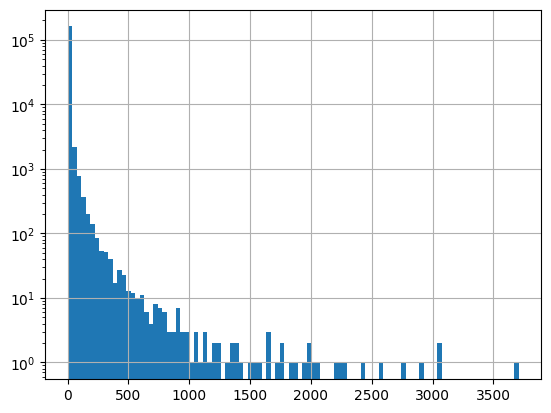

In [ ]:
og_df['popularity'].hist(bins=100, log=True)

<Axes: >

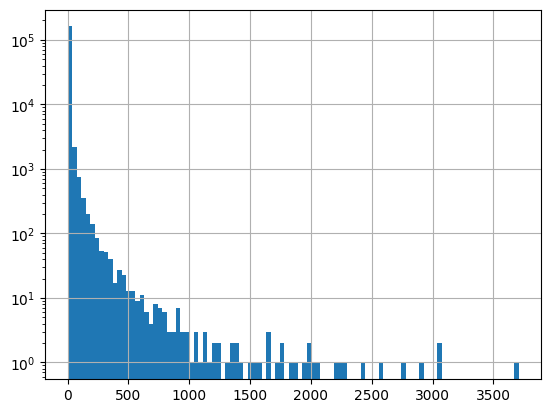

In [ ]:
df['popularity'].hist(bins=100, log=True)

### 'B' feladat: A tévéműsorok nyelve és népszerűsége közötti kapcsolat elemzése

In [ ]:
df.columns

Index(['id', 'name', 'number_of_seasons', 'number_of_episodes', 'vote_count',
       'vote_average', 'adult', 'popularity', 'episode_run_time',
       'OG_language_Abkhazian',
       ...
       'languages_Ojibwa', 'languages_Faroese', 'languages_Arabic',
       'languages_Kinyarwanda', 'languages_Gujarati', 'languages_Herero',
       'languages_Armenian', 'languages_Welsh', 'languages_Romansh',
       'languages_Luxembourgish'],
      dtype='object', length=292)

Ketté bontom az adathalmazt a nyelvek alapján

In [ ]:
#angol nyelvű sorozatok

df_english= df[df['OG_language_English']==True]

In [ ]:
#nem angol nyelvű sorozatok

df_international=df[df['OG_language_English']==False]

In [ ]:
# legnépszerűbb nemzetközi és angol nyelvű műsor

print(df_english[df_english['popularity']==df_english['popularity'].max()]['name'])
print(df_international[df_international['popularity']==df_international['popularity'].max()]['name'])

1773    The Late Show with Stephen Colbert
Name: name, dtype: object
3034    Batang Quiapo
Name: name, dtype: object


In [ ]:
#top 10 angol nyelvű műsor

top_english = df_english.sort_values(by='popularity', ascending=False).head(10)
print("Top 10 Angol:")
print(top_english[['name', 'popularity']])

Top 10 Angol:
                                         name  popularity
1773       The Late Show with Stephen Colbert    3707.008
3599   The Late Late Show with Craig Ferguson    2898.984
4570  The Tonight Show Starring Johnny Carson    2747.685
1601   The Tonight Show Starring Jimmy Fallon    2419.997
904                            The Daily Show    2016.781
3327                        Coronation Street    1837.590
2545           Late Show with David Letterman    1753.537
13                             Grey's Anatomy    1647.218
5198                    Good Mythical Morning    1646.037
4627              Late Night with Seth Meyers    1545.909


In [ ]:
#top 10 nemzetközi műsor

top_international = df_international.sort_values(by='popularity', ascending=False).head(10)
print("Top 10 Angol:")
print(top_international[['name', 'popularity']])

Top 10 Angol:
                                 name  popularity
3034                    Batang Quiapo    3065.138
2284                       Tagesschau    3049.228
4677            Chronicles of the Sun    2593.643
8649            Pira-Pirasong Paraiso    2278.406
7202    Come Home Love: Lo and Behold    2232.167
4329                  Revenge is mine    2207.068
150150                       Alliance    2071.972
14917                    Binnelanders    1977.475
13850                       Tozluyaka    1968.201
2645                   Land of Desire    1937.067


In [ ]:
#plotly-s eloszlás

trace1 = go.Histogram(x=df_english['popularity'], name='Angol nyelvű')
trace2 = go.Histogram(x=df_international['popularity'], name='Nem angol nyelvű')

fig = make_subplots()
fig.add_trace(trace1)
fig.add_trace(trace2)

fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.6)
fig.update_layout(title_text='Angol és nem angol nyelvű tévéműsorok népszerűségi eloszlása',
                  xaxis_title='Népszerűség',
                  yaxis_title='Műsorok száma (logaritmikus)',
                  yaxis_type='log',
                  legend_title="Nyelv")
fig.show()

In [ ]:
#az összes olyan oszlop eldobása, amelynek köze lehet ahhoz, hogy nemzetközi sorozatok rosszabbul teljesítenek (pl.: többeket érnek el az angol nyelvűek)

df_no_language=df.copy()

col0 = df_no_language.filter(like='OG_language').columns
col1 = df_no_language.filter(like='languages').columns

df_no_language.drop(columns=col0, inplace=True)
df_no_language.drop(columns=col1, inplace=True)
df_no_language.drop(columns='vote_count', inplace=True)

df_no_language.columns


Index(['id', 'name', 'number_of_seasons', 'number_of_episodes', 'vote_average',
       'adult', 'popularity', 'episode_run_time', 'startdate', 'has_homepage',
       'type_Documentary', 'type_Miniseries', 'type_News', 'type_Reality',
       'type_Scripted', 'type_Talk Show', 'type_Video', 'status_Canceled',
       'status_Ended', 'status_In Production', 'status_Pilot',
       'status_Planned', 'status_Returning Series', 'genres_Action',
       'genres_Romance', 'genres_Soap', 'genres_Music', 'genres_Documentary',
       'genres_Musical', 'genres_War', 'genres_History', 'genres_Talk',
       'genres_News', 'genres_Reality', 'genres_Sci-Fi', 'genres_Animation',
       'genres_Family', 'genres_Drama', 'genres_Comedy', 'genres_Mystery',
       'genres_Politics', 'genres_Fantasy', 'genres_Western', 'genres_Kids',
       'genres_Adventure', 'genres_Crime'],
      dtype='object')

In [ ]:
input= list(df_no_language.columns)

In [ ]:
input.remove("name")
input.remove('popularity')
input.remove('id')

In [ ]:
X=df_train[input]
y=df_train['popularity']

Az így "megkopasztott" adathalmazt újra fittelem a modellemre

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, min_samples_split= 2, min_samples_leaf= 2, max_features= 'auto', max_depth= None, bootstrap= False)
rf_model.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(bootstrap=False, max_features='auto', min_samples_leaf=2,
                      random_state=42)

In [ ]:
y_pred = rf_model.predict(X)


In [ ]:
mape = calculate_mape(y, y_pred)


In [ ]:
mape

22.812886508523057

Az eredmény rosszabb lett, így láthatjuk, hogy ezek az oszlopok fontosak a modellünk helyes működése érdekében.

#### Nyelvi normalizálás
Következő feladatomként igyekeztem normalizálni a népszerűséget, hogy a nemzetközi és angol nyelvű műsorok jobban összehasonlíthatók legyenek.

In [ ]:
#skálázás

scaler = MinMaxScaler()

In [ ]:
#angol nyelvű sorozatok illesztése
df_english['popularity_norm'] = scaler.fit_transform(df_english[['popularity']])
#nemzetközi sorozatok illesztése az angol nyelvű sorozatokra fittelt scaler-rel
df_international['popularity_norm_old_fit'] =scaler.transform(df_international[['popularity']])
#nemzetközi sorozatok illesztése újscaler-rel
df_international['popularity_norm'] = scaler.fit_transform(df_international[['popularity']])

NameError: ignored

In [ ]:
#plotly-s eloszlás, hogy lássuk a különbséget

trace1 = go.Histogram(x=df_english['popularity_norm'], name='Angol nyelvű normalizált')
trace2 = go.Histogram(x=df_international['popularity_norm_old_fit'], name='Nemzetközi normalizált angol alapján')
trace3 = go.Histogram(x=df_international['popularity_norm'], name='Nemzetközi normalizált')

fig = make_subplots()
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.add_trace(trace3)

fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.6)
fig.update_layout(title_text='Angol és nem angol nyelvű tévéműsorok népszerűségi eloszlása',
                  xaxis_title='Népszerűség',
                  yaxis_title='Műsorok száma (logaritmikus skála)',
                  yaxis_type='log',
                  legend_title="Nyelv")
fig.show()

A táblázaton láthatjuk különbség a két nemzetközi normalizált adat között van, de nem jelentős.

In [ ]:
#új oszlop létrehozása, hogy a df_english és a dr_international ugyanazokkal az oszlopokkal rendelkezzen

df_english['popularity_norm_old_fit']=df_english['popularity_norm']

In [ ]:
#dataframe-ek mergelése

df_combined = pd.concat([df_english, df_international], ignore_index=True)

In [ ]:
df_combined.sort_values(by='popularity', ascending=False).head(10)

In [ ]:
df_english['popularity_norm'].mean()

In [ ]:
df_international['popularity_norm_old_fit'].mean()

In [ ]:
df_international['popularity_norm'].mean()

In [ ]:
df_combined['popularity_norm'].mean()

In [ ]:
df_combined['popularity_norm_old_fit'].mean()

A feljebb található adatokból a következő olvasható ki: a normalizálás a nemzetközi átlagon 2,5%-ot növelt, ami a teljes, kombinált adathalmazon egy csaknem 1,5%-os növekedést jelent.

## 3. (extra) feladat: Havi/ évi trendek népszerűség szempontjából
A népszerűség irányán maradva úgy gondoltam, hogy érdekes lenne még megvizsgálni, hogy milyen trend figyelhető meg az adatokban évi és havi szinten. A népszerűséget az adot hónapban/évben található műsorok számosságával állítottam kontrasztba

In [ ]:
og_df.columns

In [ ]:
#to date time
og_df['first_air_date']=pd.to_datetime(og_df['first_air_date'])

In [ ]:
#új oszlopok létrehozása évhez és hónaphoz

og_df['year'] = og_df['first_air_date'].dt.year
og_df['month'] = og_df['first_air_date'].dt.month

In [ ]:
#évi és havi számosság
year = og_df['year'].value_counts().sort_index()
month = og_df['month'].value_counts().sort_index()

#évi és havi átlag népszerűség
year_pop = og_df.groupby('year')['popularity'].mean()
month_pop = og_df.groupby('month')['popularity'].mean()

In [ ]:
#plotly ábrázolás az évi adatokhoz

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Bar(x=year.index, y=year.values, name='Évi számosság'), secondary_y=False)
fig.add_trace(go.Scatter(x=year_pop.index, y=year_pop.values, mode='lines+markers', name='Évi népszerűség'),secondary_y=True)

fig.update_layout(title='Évi trendek',
                  xaxis_title='Év',
                  yaxis_title='Műsorok Száma / Átlagos Népszerűség',
                  template='plotly_dark',
                  legend_title="Adattípus")
fig.show()


Talán ez a legérdekesebb eredmény. Megfigyelhetjük, hogy a legmagasabb átlag népszerűség a 1940 és 1970 között található, gyakorlatilag tükrözve a sorozatok számát, ami manapság magas.

Bár persze, régebben sokkal kisebb volt a mintavétel, de ott is minden évben több mint 100 műsor található meg, így úgy gondolom, nem torzítja túlságosan az adatokat.

De akkor mitől lehet az a nagy ugrás?

Két gondolatom van:
- Egyrészt úgy gondolom, hogy a műsorkészítés akkor egy sokkal kiváltságosabb dolog volt, így nagyobb eséllyel készültek minőségi műsorok.

- Másrészt el tudom képzelni, hogy mivel azok a népszerűségi mutatók feltehetően később készültek és lettek digitalizálva, az eredményt nagyban befolyásolja a nézők nosztalgiája

In [ ]:
#plotly ábrázolás az havi adatokhoz


fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Bar(x=month.index, y=month.values, name='Havi számosság'), secondary_y=False)
fig.add_trace(go.Scatter(x=month_pop.index, y=month_pop.values, mode='lines+markers', name='Havi népszerűség'),secondary_y=True)

fig.update_layout(title='Havi trendek',
                  xaxis_title='Hónap',
                  yaxis_title='Műsorok Száma / Átlagos Népszerűség',
                  template='plotly_dark',
                  legend_title="Adattípus")
fig.show()


Ez a diagram már kevésbé meglepő, inkább csak megerősítette bennem azt, amit a sorozataim nézésekor tapasztalok. A legtöbb népszerű sorozat szeptemberben indul, mivel a nyár után sokak nyitottak egy vadiúj sorozatba belenézni

# Összegzés

Úgy gondolom, hogy ez egy nagyon érdekes feladat volt.

Legmeglepőbb dolog benne számomra az volt, hogy a popularity oszlop teljesen más eredményt hozott ki legnépszerűbbnek, mint amire én számítottam.

Úgy gondolom, hogy a nézőszám valahogy nagyobb súllyal szerepelhetett benne szummázva, hiszen az angol nyelvűek listáján szinte csak Late Night Show-kat lehetett látni, melyek egész évben mennek.

Megpróbáltam ezt ellensúlyozni egy olyan népszerűségi mutatóval, ahol a vote_count és vote_average függvényeket is használtam és úgy próbáltam korrigálni, de így két fontos oszlopot elvesztettem a modellemből és így a pontosságom romlott így ezt végül töröltem.

Úgy érzem, hogy további munkával és hiperparaméter optimalizációval tovább lehetne javítani az eredményt, de attól tartok, hogy az sok erőforrást igényelne